This notebook explores, transforms, and visualizes data from the classic novel PRIDE AND PREJUDICE by Jane Austen.

Table of Contents:
1. Load Novel
2. Clean Dataset
3. Perform Sentiment Analysis
4. Visualize Character-Adjacent Words
5. Plot Metrics Across Chapters

1. Load Novel

In [20]:
!pip install PyPDF2
!pip install textstat

!pip install --user -U nltk
# !pip install --user -U numpy

# Import libraries
from urllib.request import urlopen
import requests
from PyPDF2 import PdfReader
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sia
import pandas as pd
import string
import matplotlib.pyplot as plt
import numpy as np
import textstat as ts


import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [21]:
# Set URL of the plain-text version of the novel on Project Gutenberg
url = 'https://www.gutenberg.org/files/1342/1342-0.txt'

with urlopen(url) as response:
     body = response.read()

# Decode the text
pandp_txt = body.decode('utf-8')

# Replace escaped characters, tabs, and stylized punctuation marks
repl = {'\n':'','\t':'','\ufeff':'','\r':' ','       ':' ','“':'"','”':'"','’':"'"}
for c in repl:
     pandp_txt = pandp_txt.replace(c, repl[c])

In [22]:
# Tokenize pandp_txt into a list of words (wt_all) and sentences (st_all)
wt_all = word_tokenize(pandp_txt)
st_all = sent_tokenize(pandp_txt)

In [23]:
pandp_txt[:100]

'*** START OF THE PROJECT GUTENBERG EBOOK 1342 ***     [Illustration:       GEORGE ALLEN        PUBLI'

In [24]:
st_all[:1]

["*** START OF THE PROJECT GUTENBERG EBOOK 1342 ***     [Illustration:       GEORGE ALLEN        PUBLISHER        156 CHARING CROSS ROAD         LONDON       RUSKIN HOUSE      ]      [Illustration:     _Reading Jane's Letters._      _Chap 34._      ]       PRIDE."]

In [25]:
wt_all[:3]

['*', '*', '*']

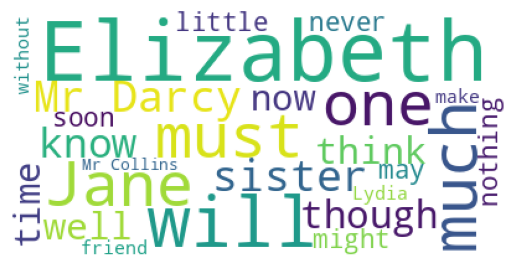

In [26]:
# Create stopword list:
stopwords = set(STOPWORDS)

# Add more words to ignore
stopwords.update(["S","re", "say", "said", "don't", "didn't"])

# Redo stop words. Limit number of words
wordcloud = WordCloud(stopwords=stopwords, max_words=25, \
                      background_color="white").generate(pandp_txt)

# Display wordcloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

2. Clean dataset

In [27]:
# Create table of contents
toc_start = st_all[3].find('CONTENTS') + len ('CONTENTS    ')
toc_end = st_all[3].find('It is a truth') - len('     Chapter 1  ')
chap_title = st_all[3][toc_start:toc_end].split('    ')

# Exclude Project Gutenberg intro content at beginning of document
st0 = st_all[3].split('    ') + st_all[4:]

# Find the beginning and end of the novels
start = [st0.index(x) for x in st0 if 'Chapter 1' in x][1]
end = [st0.index(x) for x in st0 if '***' in x][1]
st1 = st0[start:end]


# llm proposed fix
# start_list = [st0.index(x) for x in st0 if 'Chapter 1' in x]
# start = start_list[1] if len(start_list) > 1 else start_list[0] if start_list else 0
# end = [st0.index(x) for x in st0 if '***' in x][0] # changed to 0 to get first instance of "***"
# st1 = st0[start:end]




In [28]:
# Tokenizing has split a piece of dialogue and its attribution
st1[6:8]

['There is much more difference as to their best work than in the case of those others who are loved "by allowance" by convention, and because it is felt to be the right and proper thing to love them.',
 'And in the sect--fairly large and yet unusually choice--of Austenians or Janites, there would probably be found partisans of the claim to primacy of almost every one of the novels.']

In [29]:
# If first character of sentence is lowercase (e.g "cried"),
# assume that it is actually the second half of one sentence and re-combine in a list
st2 = []
for i, sent in enumerate(st1):
    if str.islower(sent[0]):
        st2.append(st1[i-1] + ' ' + st1[i])
    else:
        st2.append(st1[i])

In [31]:
nltk.download('vader_lexicon')

# Define function to gather additional sentence information
sid = sia()
def gather_sentence(sentence):
    sent_dict = {}
    ss = sid.polarity_scores(sentence)
    sent_dict['sent'] = sentence
    sent_dict['sent_simple'] = sentence.replace("'s",'').translate(str.maketrans('', '', string.punctuation)).lower()
    sent_dict['word_ct'] = len(sentence.split(' '))
    sent_dict['neg_pol'] = ss['neg']
    sent_dict['neu_pol'] = ss['neu']
    sent_dict['pos_pol'] = ss['pos']
    sent_dict['compound'] = ss['compound']
    if ss['compound'] > 0:
        compound_txt = 'positive'
    elif ss['compound'] < 0:
        compound_txt = 'negative'
    else:
        compound_txt = 'neutral'
    sent_dict['compound_txt'] = compound_txt
    sent_dict['read_level'] = ts.text_standard(sentence, float_output=True)
    sent_dict['read_time'] = ts.reading_time(sentence)
    sent_dict['syl_ct'] = ts.syllable_count(sentence)
    sent_dict['monosyl_ct'] = ts.monosyllabcount(sentence)
    sent_dict['polysyl_ct'] = ts.polysyllabcount(sentence)
    return sent_dict

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [32]:
st2[0]

'Cross Road.'

In [33]:
# Loop through sentences and if they match a regex starting with "Chapter"
# Then remove the word "Chapter" from these sentences and create a list with the chapter number
# Generate a dictionary with this information
dict_lst = []
chap_lst = []
for s in st2:
    reg = '(Chapter) [0-9]+'
    m = re.search(reg, s)
    if m:
        dict = {}
        chapter = m.group()
        dict['sentence'] = s.replace(chapter + '  ', '')
        dict['chapter'] = chapter.split(' ')[1]
        dict_lst.append(dict)
        chap_lst.append(chapter.split(' ')[1])
    else:
        dict = {}
        dict['sentence'] = s
        dict['chapter'] = chap_lst[-1]
        dict_lst.append(dict)

# Create dataframe from list of dictionaries
a_df = pd.DataFrame.from_dict(dict_lst)

# Apply the gather_sentence function to each sentence
major_sent_dict = [gather_sentence(x) for x in a_df['sentence']]

# Create a new dataframe to capture the additional data
b_df = pd.DataFrame(major_sent_dict)
b_df = b_df.drop(['sent'], axis=1)

# Merge original sentence dataframe with additional dataframe
df = pd.merge(a_df, b_df, left_index=True, right_index=True)

# Create integer version of Chapter
df['chapter_int'] = [int(x) for x in list(df['chapter'])]

# Split the book into six parts: 10-11 chapters per part
df['part'] = pd.cut(df['chapter_int'],bins=[1,10,20,30,40,50,61], labels=[1,2,3,4,5,6], include_lowest=True)

df.head(2)

IndexError: list index out of range

In [ ]:
a_df.head()

In [ ]:
df[df['sentence'].str.contains('I cannot fix on the hour')]

In [ ]:
example_sentence = df['sentence'][2834]
example_sentence

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sia
sid = sia()
sid.polarity_scores(example_sentence)

In [ ]:
# Create a test sentence to use
tester = df['sentence'][0]

# Display count of sentences in new dataframe
print(
    'count of sentences: ', len(df), ' | '
    'count of chapters: ', len(chap_title)
)

In [ ]:
# Print proportion of sentences by compound sentiment score
(df.groupby('compound_txt').count())['compound'] / len(df)

In [ ]:
# Describe the new textstat metrics across the dataset
df[['sentence','read_level','read_time','syl_ct','monosyl_ct','polysyl_ct']].describe()

In [ ]:
# Print the overall textstat metrics for the novel
print(
    'standard reading level: ',ts.text_standard(pandp_txt, float_output=True),'\n',
    'reading_time: ',ts.reading_time(pandp_txt, ms_per_char=14.69),'\n',
    'prop mono syls: ',ts.monosyllabcount(pandp_txt)/ts.syllable_count(pandp_txt),'\n',
    'prop poly syls: ',ts.polysyllabcount(pandp_txt)/ts.syllable_count(pandp_txt)
    )

In [ ]:
# Define a function to translate the part of speech tag from NLK to the one WordNet Lemmatizer uses
def translate_pos(nltk_tag):
    if nltk_tag.startswith('J'): # Adjective
        return 'a'
    elif nltk_tag.startswith('V'): # Verb
        return 'v'
    elif nltk_tag.startswith('N'): # Noun
        return 'n'
    elif nltk_tag.startswith('R'): # Adverb
        return 'r'
    else:
        return 'n'

In [ ]:
pos_tag(df['sentence'][5].split(' '))

In [ ]:
df[df['sentence'].str.contains('exclaimed')]['sentence']

In [ ]:
# Define a function to extract details at the word level from a sentence
lemmatizer = WordNetLemmatizer()

def create_word_dictionary(sentence, chapter, sent_index):
    sent = sentence.split(' ')
    sent1 = [x.replace("'s",'').translate(str.maketrans('', '', string.punctuation)) for x in sent]
    part = pos_tag(sent1)
    parts = [x[1] for x in part]
    word_dict_lst = []
    for i, word in enumerate(sent1):
        word_dict = {}
        word_dict['original_word'] = word
        word_dict['part_of_speech'] = parts[i]
        pos_for_lem = translate_pos(parts[i])
        word_dict['pos_for_lem'] = pos_for_lem
        word_dict['word_lower'] = word.lower()
        #word_dict['word_lem'] = lemmatizer.lemmatize(word.lower(),pos_for_lem)
        word_dict['chapter'] = chapter
        word_dict['chapter_int'] = int(chapter)
        word_dict['sent_index'] = sent_index
        word_dict['part'] = df['part'][sent_index]
        word_dict_lst.append(word_dict)
    return word_dict_lst

In [ ]:
# For each sentence, apply the create_word_dictionary function
major_dict = []
for i, sentence in enumerate(a_df['sentence']):
    chapter = a_df['chapter'][i]
    sent_index = i
    new_dict = create_word_dictionary(sentence, chapter, sent_index)
    major_dict.append(new_dict)

# Make the list of dictionaries into one dictionary
major_dict1 = [x for sublist in major_dict for x in sublist]

# Create a new word-level dictionary based on the new dictionary
a_wdf = pd.DataFrame(major_dict1)
a_wdf['copy_index'] = a_wdf.index

In [ ]:
# Create a dataframe with each word in the text and its Part of Speech, as identified by NLTK
wdf1 = a_wdf[['original_word', 'part_of_speech']].value_counts().reset_index()
wdf1.rename(columns={0:'ct'}, inplace=True)

# Loop through a unique list of the words and identify Part of Speech with NLTK
pos_mc = []
occ_ct = []
word_uni = set(wdf1['original_word'])
for word in word_uni:
    # Take the Part of Speech in the 0th position (the POS that NLTK identified for that word most often)
    mc = list(wdf1[wdf1['original_word']==word]['part_of_speech'])[0]
    ct = wdf1[wdf1['original_word']==word]['ct'].sum()
    pos_mc.append(mc)
    occ_ct.append(ct)

# Create a new dataframe with the unique list of lemmatized words, their most common part of speech,
# and the number of occurrences of that word in the text
tup = list(zip(word_uni, pos_mc, occ_ct))
b_wdf = pd.DataFrame(tup,columns=['word_mc', 'part_of_speech_mc','ct_mc'])
wdf = pd.merge(a_wdf, b_wdf, left_on='original_word', right_on='word_mc')
wdf = wdf.sort_values('copy_index').reset_index()
wdf.drop(['word_mc','ct_mc','index','copy_index'], inplace=True, axis=1)

In [ ]:
# For each word, use the most commonly assigned part of speech to lemmatize
word_lem = []
for i, r in wdf.iterrows():
    w_lem = lemmatizer.lemmatize(r['word_lower'],r['pos_for_lem'])
    word_lem.append(w_lem)

wdf['word_lem'] = word_lem

In [ ]:
wdf[wdf['word_lower']!=wdf['word_lem']][['original_word','word_lem']]

In [ ]:
wdf.head()

In [ ]:
lemmatizer.lemmatize('exclaimed')

In [ ]:
lemmatizer.lemmatize('exclaimed','v')

In [ ]:
pos_tag(df['sentence'][1086].split(' '))

In [ ]:
pos_tag(df['sentence'][1086].translate(str.maketrans('', '', string.punctuation)).split(' '))

In [ ]:
# Count how many times Elizabeth and Darcy are mentioned across the chapters
e = [(int('elizabeth' == x)|(int('lizzy' == x))) for x in wdf['word_lem']]
d = [int('darcy' == x) for x in wdf['word_lem']]

wdf['mention_e'] = e
wdf['mention_d'] = d

In [ ]:
# Obtain fhe following summary metrics on the chapter level:
# Count of sentences, count of words, average word count per sentence, average sentiment, count of Elizabeth mentions,
# count of Darcy mentions, proportion of positive sentences, proportion of negative sentences

sent_ct = list((df['chapter'].value_counts()).sort_index(ascending=True))
word_ct = list(df.groupby(['chapter']).sum()['word_ct'])
avg_word_ct = list(df.groupby(['chapter']).mean()['word_ct'])
avg_pol = list(df.groupby(['chapter']).mean()['compound'])
e_ment = list(wdf.groupby(['chapter']).sum()['mention_e'])
d_ment = list(wdf.groupby(['chapter']).sum()['mention_d'])
pos_sent = list(df[df['compound_txt']=='positive'].groupby(['chapter']).count()['sentence'])
neg_sent = list(df[df['compound_txt']=='negative'].groupby(['chapter']).count()['sentence'])

cdf = pd.DataFrame(df.chapter.unique(), columns=['chapter'])
# Chapter name
cdf['chapter'] = list(df.chapter.unique())
cdf['chapter_int'] = [int(x) for x in list(df.chapter.unique())]
# Sentence count in chapter
cdf['sent_ct'] = sent_ct
# Total word count in chapter
cdf['word_ct'] = word_ct
# Average word count across sentences in chapter
cdf['avg_word_ct'] = avg_word_ct
# Average polarity of chapter
cdf['avg_pol'] = avg_pol
# Count of mentions of "Elizabeth"
cdf['e_ment'] = e_ment
# Count of mentions of "Darcy"
cdf['d_ment'] = d_ment
# Count of sentences with positive sentiment
cdf['pos_sent'] = pos_sent
# Count of sentences with negative sentiment
cdf['neg_sent'] = neg_sent
# Proportion of sentences that are positive
cdf['pos_prop'] = cdf['pos_sent']/cdf['sent_ct']
# Proportion of sentences that are negative
cdf['neg_prop'] = cdf['neg_sent']/cdf['sent_ct']
# Ratio of positive to negative sentence count
cdf['pos_neg_ratio'] = cdf['pos_sent']/cdf['neg_sent']
# Ratio of Darcy to Elizabeth name occurrence
cdf['d_e_ratio'] = cdf['d_ment']/cdf['e_ment']

cdf.head()

In [ ]:
# Obtain fhe following summary metrics on the Part level (group of 10-11 parts):
# count of sentences, count of words, average word count per sentence, average sentiment, count of Elizabeth mentions,
# count of Darcy mentions, proportion of positive sentences, proportion of negative sentences

sent_ct = list((df['part'].value_counts()).sort_index(ascending=True))
word_ct = list(df.groupby(['part']).sum()['word_ct'])
avg_word_ct = list(df.groupby(['part']).mean()['word_ct'])
avg_pol = list(df.groupby(['part']).mean()['compound'])
e_ment = list(wdf.groupby(['part']).sum()['mention_e'])
d_ment = list(wdf.groupby(['part']).sum()['mention_d'])
pos_sent = list(df[df['compound_txt']=='positive'].groupby(['part']).count()['sentence'])
neg_sent = list(df[df['compound_txt']=='negative'].groupby(['part']).count()['sentence'])

pdf = pd.DataFrame(df.part.unique(), columns=['part'])
# Part of novel (10-11 chapters per part)
pdf['part'] = list(df.part.unique())
# Sentence count in part
pdf['sent_ct'] = sent_ct
# Total word count in part
pdf['word_ct'] = word_ct
# Average word count across sentences in part
pdf['avg_word_ct'] = avg_word_ct
# Average polarity of part
pdf['avg_pol'] = avg_pol
# Count of mentions of "Elizabeth"
pdf['e_ment'] = e_ment
# Count of mentions of "Darcy"
pdf['d_ment'] = d_ment
# Count of sentences with positive sentiment
pdf['pos_sent'] = pos_sent
# Count of sentences with negative sentiment
pdf['neg_sent'] = neg_sent
# Proportion of sentences that are positive
pdf['pos_prop'] = pdf['pos_sent']/pdf['sent_ct']
# Proportion of sentences that are negative
pdf['neg_prop'] = pdf['neg_sent']/pdf['sent_ct']
# Ratio of positive to negative sentence count
pdf['pos_neg_ratio'] = pdf['pos_sent']/pdf['neg_sent']
# Ratio of Darcy to Elizabeth name occurrence
pdf['d_e_ratio'] = pdf['d_ment']/pdf['e_ment']

pdf

3. Perform Sentiment Analysis

In [ ]:
# Print basic metrics
print(
    'total df row count:', len(df), '| '
    'character count:', len(pandp_txt), '| '
    'word count:', len(wdf), '| '
    'sentence count:', len(sent)
)

4. Visualize Character-Adjacent Words

In [ ]:
# Create lists to form dataframe for "Adjacent Words"
wrd_adj = []
wrd_person = []
wrd_pos = []
sent_index = []
characters = ['darcy','elizabeth','lizzy']
# Loop through each sentence and identify the words that are adjacent to mentions of Elizabeth or Darcy
for n, s in enumerate(df['sent_simple']):
    ss = s.split()
    for i, e in enumerate(ss):
        if e in characters:
            # For cases where the character name is NOT the first in the sentence, collect data
            if i != 0:
                # Handle cases where either character are referred to as Miss or Mr
                if ss[i-1] in ('miss','mr'):
                    w_prior = ss[i-2]
                else:
                    w_prior = ss[i-1]
                w_pos = wdf[wdf['original_word']==w_prior]['part_of_speech_mc'].values
                # Collect the name of the character
                wrd_person.append(e)
                # If the word exists in the Part of Speech dataframe, collect the Part of Speech
                if len(w_pos)>0:
                    pos = w_pos[0]
                else:
                    pos = 'None found'
                wrd_pos.append(pos)
                # Collect the word prior to the name
                wrd_adj.append(lemmatizer.lemmatize(w_prior.lower(),translate_pos(pos)))
                # Collect sentence index
                sent_index.append(n)
            # For cases where the character name is NOT the LAST in the sentence, collect data
            if i != len(ss)-1:
                w_after = ss[i+1]
                w_pos = wdf[wdf['original_word']==w_after]['part_of_speech_mc'].values
                # Collect the name of the character
                wrd_person.append(e)
                # Collect the part of speech
                if len(w_pos)>0:
                    pos = w_pos[0]
                else:
                    pos = 'None found'
                wrd_pos.append(pos)
                # Collect the word after the name
                wrd_adj.append(lemmatizer.lemmatize(w_after.lower(),translate_pos(pos)))
                # Collect sentence index
                sent_index.append(n)

# Create a new dataframe with the adjacent word, relevant character, and part of speech
tup = list(zip(wrd_adj, wrd_person, wrd_pos, sent_index))
adf = pd.DataFrame(tup,columns=['adjacent_word', 'person','pos','sent_index'])
adf.head()

In [ ]:
# Define a function to create wordcloud with arguments for Character, Part of Speech, and Stopwords
def create_cloud(character:list, pos, stop=['is']):
    ser = adf[(adf['person'].isin(character))&(adf['pos'].isin(pos))]['adjacent_word']
    lst = list(ser)
    strng = ' '.join(lst)
    wordcloud = WordCloud(stopwords=stop, max_words=25, \
                        background_color="white").generate(strng)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

# Create lists with the relevant Part of Speech NLTK codes
adjective = ['JJ','JJR','JJS']
verb = ['VB','VBG','VBD','VBN','VBP','VBZ']
adverb = ['RB','RBR','RBS','RP']


In [ ]:
e_verbs = adf[(adf['person'].isin(['elizabeth','lizzy']))&(adf['pos'].isin(verb))]['adjacent_word']
e_verbs.value_counts()[:5]

In [ ]:
# Generate Wordclouds using the new function
e = ['elizabeth','lizzy']
d = ['darcy']
a_stop = ['is']
v_stop = ['say','be','have','reply','do']
adv_stop = ['so','only']

print('Elizabeth Adjectives:')
create_cloud(e,adjective,stop=a_stop)
print('Darcy Adjectives:')
create_cloud(d,adjective,stop=a_stop)

print('Elizabeth Verbs:')
create_cloud(e,verb,stop=v_stop)
print('Darcy Verbs:')
create_cloud(d,verb,stop=v_stop)

print('Elizabeth Adverbs:')
create_cloud(e,adverb,stop=adv_stop)
print('Darcy Adverbs:')
create_cloud(d,adverb,stop=adv_stop)

5. Plot Metrics Across Chapters

In [ ]:
def create_line_graph(x_axis, y_axis, title, xlabel, ylabel, level='chapter'):
    x = x_axis
    y = y_axis
    if level == 'part':
        x_ticks = pdf['part']
        bins = 6
    else:
        x_ticks = cdf['chapter_int']
        bins = 10
    plt.plot(x,y)
    plt.title(label=title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.locator_params(axis='x', nbins=6)

In [ ]:
# Average Polarity by Part
x_axis = pdf['part']
y_axis = pdf['avg_pol']
title = 'Average Sentence Sentiment by Part'
xlabel = 'Part of Novel'
ylabel = 'Average Sentence Polarity'
create_line_graph(x_axis, y_axis, title, xlabel, ylabel,level='part')

In [ ]:
# Average Polarity by Chapter
x_axis = cdf['chapter_int']
y_axis = cdf['avg_pol']
title = 'Average Sentence Sentiment by Chapter'
xlabel = 'Chapter'
ylabel = 'Average Sentence Polarity'
create_line_graph(x_axis, y_axis, title, xlabel, ylabel, level='chapter')

In [ ]:
# Average word count by Chapter
x_axis = cdf['chapter_int']
y_axis = cdf['word_ct']
title = 'Word Count by Chapter'
xlabel = 'Chapter'
ylabel = 'Word Count'
create_line_graph(x_axis, y_axis, title, xlabel, ylabel,'chapter')

In [ ]:
# Define a new function to plot word occurrence on a line graph
def plot_word(wordlist: list, level='chapter'):
    wordbool = [int(w in wordlist) for w in wdf['word_lem']]
    wdf['plot_word'] = wordbool
    if level == 'part':
        plot_df1 = wdf.groupby(['part']).sum()
        xlabel = 'Part'
        bins = 6
    elif level == 'chapter':
        plot_df1 = wdf.groupby(['chapter_int']).sum()
        xlabel = 'Chapter'
        bins = 10
    x = plot_df1.index
    y = plot_df1['plot_word']
    x_ticks = plot_df1.index

    plt.xticks(ticks=x_ticks)
    plt.plot(x,y)
    titl = "'"+wordlist[0]+"'"+" in Price & Prejudice"
    plt.title(titl)
    plt.locator_params(nbins=bins)
    plt.xlabel(xlabel)
    plt.ylabel('Count of Occurrences')

In [ ]:
# Create stopword list:
stopwords = set(STOPWORDS)

# Add more words to ignore
stopwords.update(["S","re", "say", "said", "don't", "didn't"])


In [ ]:
wdf[wdf['word_lem'] == 'love']

In [ ]:
# Plot occurrences of the word "love" (and similar ones) across the chapters
plot_word(['love'],'chapter')

In [ ]:
plot_word(['love'],'part')

In [ ]:
plot_word(['marry'])

In [ ]:
plot_word(['wickham'])

In [ ]:
plot_word(['catherine'])

In [ ]:
plot_word(['lydia'])

In [ ]:
plot_word(['collins'])

In [ ]:
plot_word(['friend'],'part')

In [ ]:
plot_word(['pride'])

In [ ]:
plot_word(['prejudice'])

In [ ]:
plot_word(['money','pounds','inheritance'])

In [ ]:
# Plot occurrences of the word "nod" (and similar ones) across the chapters
plot_word(['laugh'])

In [ ]:
# Plot line graph of Darcy and Elizabeth mention count by chapter

x = cdf.chapter_int
y1 = cdf['e_ment']
y2 = cdf['d_ment']

plt.xticks(ticks=cdf.chapter_int)
plt.plot(x,y1, label='Elizabeth')
plt.plot(x,y2,label='Darcy')
plt.legend()
plt.locator_params(nbins=10)
plt.title('Name Mentions by Chapter')
plt.xlabel('Chapter')
plt.ylabel('Count of Name Occurrences')

In [ ]:
# Plot line graph of Darcy and Elizabeth mention count by chapter

x = cdf.chapter_int
y1 = cdf['e_ment']
y2 = cdf['d_ment']

plt.xticks(ticks=cdf.chapter_int)
plt.plot(x,y1, label='Elizabeth')
plt.plot(x,y2,label='Darcy')
plt.legend()
plt.locator_params(nbins=10)
plt.title('Name Mentions by Chapter')
plt.xlabel('Chapter')
plt.ylabel('Count of Name Occurrences')

In [ ]:
# Plot line graph of positive vs negative sentence count proportion

x = cdf.chapter_int
y1 = cdf['pos_prop']
y2 = cdf['neg_prop']

plt.xticks(ticks=cdf.chapter_int)
plt.plot(x,y1, label='pos')
plt.plot(x,y2,label='neg')
plt.locator_params(nbins=10)
plt.legend()
plt.title('Sentiment Polarity Proportion')
plt.xlabel('Chapter')
plt.ylabel('Proportion of Sentences')